## Setup

The following packages are required to run the analysis. If not already installed, the packages will be installed using `pip`.

In [ ]:
!pip install numpy
!pip install pandas
!pip install scipy
!pip install hmmlearn
!pip install statsmodels
!pip install tqdm
!pip install colorama
!pip install pyliftover

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from tqdm import tqdm
import statsmodels.api as sm
import scipy.stats as stats
import math
import glob
from pyliftover import LiftOver
import requests
import warnings

# Suppress all warnings to keep the output clean
warnings.filterwarnings("ignore")

## Specify project directories

Define the paths to the data and results directories used in the project.

In [2]:
# Specify the directories containing data and results
data_path = '/oak/stanford/groups/mrivas/projects/wgs-constraint-llm/data/'
results_path = '/oak/stanford/groups/mrivas/projects/wgs-constraint-llm/osthoag/wgs-constraint-llm/results/'

# Specify the paths to the specific data files
# https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_44/gencode.v44.chr_patch_hapl_scaff.basic.annotation.gtf.gz
gene_annotation_file_path = data_path + 'gencode.v44.basic.annotation.gtf.gz'
epi25_variants_file_path = data_path + 'epi25_variant_results.tsv.gz'
constraint_predictions_file_path = results_path + f'HMM_rgc_0.9_over20_chr2_predictions_rgc_wes.tsv.gz'
# https://zenodo.org/records/10813168/files/AlphaMissense_hg38.tsv.gz?download=1
alpha_missense_file_path = data_path + 'AlphaMissense_hg38.tsv.gz'

## Define helper methods

In [3]:
# Function to calculate effect size and variance for variants
def calculate_effect_size_and_variance(cases_df):
    ALT_AJ = cases_df['ac_case']
    ALT_ExAC = cases_df['ac_ctrl']
    REF_AJ = cases_df['an_case'] - cases_df['ac_case']
    REF_ExAC = cases_df['an_ctrl'] - cases_df['ac_ctrl']

    # Logarithmic transformation of effect size calculation
    cases_df['effect_size'] = np.log(((0.5 + ALT_AJ) * (0.5 + REF_ExAC)) / ((0.5 + REF_AJ) * (0.5 + ALT_ExAC)))
    # Variance calculation for the effect size
    cases_df['var_effect_size'] = (1 / (0.5 + REF_AJ) + 1 / (0.5 + REF_ExAC) + 1 / (0.5 + ALT_AJ) + 1 / (0.5 + ALT_ExAC))
    
    return cases_df

# Initialize liftover object to convert coordinates from hg19 to hg38
lo = LiftOver('hg19', 'hg38')

# Function to apply liftover to a single row
def liftover(row):
    lifted = lo.convert_coordinate(row['chr'], row['pos'])
    if lifted:
        # Return the first lifted coordinate if successful
        return lifted[0][0], int(lifted[0][1])
    else:
        # Return the original chromosome with position 0 if liftover fails
        return row['chr'], 0

## Load Data
This section loads the gene annotation data from a GTF file and extracts relevant information such as gene ID, gene type, gene name, and transcript details. The data is then filtered to include only protein-coding regions.

In [4]:
# Read the GTF file into a pandas DataFrame
gene_df = pd.read_csv(gene_annotation_file_path, sep='\t', comment='#', header=None, 
                      names=['chr', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attribute'], 
                      dtype={'start': int, 'end': int})

# Extract 'gene_id' from attributes
gene_df['gene_id'] = gene_df['attribute'].str.extract(r'gene_id "(.*?)"')

# Extract 'gene_type' from attributes
gene_df['gene_type'] = gene_df['attribute'].str.extract(r'gene_type "(.*?)"')

# Extract 'gene_name' from attributes
gene_df['gene_name'] = gene_df['attribute'].str.extract(r'gene_name "(.*?)"')

# Extract 'transcript_id' from attributes
gene_df['transcript_id'] = gene_df['attribute'].str.extract(r'transcript_id "(.*?)"')

# Extract 'transcript' and 'num' from transcript_id
gene_df[['transcript', 'transcript_num']] = gene_df['transcript_id'].str.split('.', expand=True)

# Extract 'transcript_name' from attributes
gene_df['transcript_name'] = gene_df['attribute'].str.extract(r'transcript_name "(.*?)"')

# Drop the original attribute column
gene_df = gene_df.drop('attribute', axis=1)

# Filter rows for protein-coding regions
gene_df = gene_df[(gene_df['gene_type'] == 'protein_coding') & (gene_df['feature'] == 'CDS')]

# Standardize the gene_id by removing any version numbers (i.e., text after the dot)
gene_df['std_gene_id'] = gene_df['gene_id'].str.split('.').str[0]

# Display the DataFrame
gene_df

,chr,source,feature,start,end,score,strand,frame,gene_id,gene_type,gene_name,transcript_id,transcript,transcript_num,transcript_name,std_gene_id
60,chr1,HAVANA,CDS,65565,65573,.,+,0,ENSG00000186092.7,protein_coding,OR4F5,ENST00000641515.2,ENST00000641515,2,OR4F5-201,ENSG00000186092
63,chr1,HAVANA,CDS,69037,70005,.,+,0,ENSG00000186092.7,protein_coding,OR4F5,ENST00000641515.2,ENST00000641515,2,OR4F5-201,ENSG00000186092
236,chr1,HAVANA,CDS,450743,451678,.,-,0,ENSG00000284733.2,protein_coding,OR4F29,ENST00000426406.4,ENST00000426406,4,OR4F29-201,ENSG00000284733
304,chr1,HAVANA,CDS,685719,686654,.,-,0,ENSG00000284662.2,protein_coding,OR4F16,ENST00000332831.5,ENST00000332831,5,OR4F16-201,ENSG00000284662
524,chr1,HAVANA,CDS,924432,924948,.,+,0,ENSG00000187634.13,protein_coding,SAMD11,ENST00000616016.5,ENST00000616016,5,SAMD11-209,ENSG00000187634
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1998488,chrM,ENSEMBL,CDS,10470,10763,.,+,0,ENSG00000212907.2,protein_coding,MT-ND4L,ENST00000361335.1,ENST00000361335,1,MT-ND4L-201,ENSG00000212907
1998495,chrM,ENSEMBL,CDS,10760,12137,.,+,0,ENSG00000198886.2,protein_coding,MT-ND4,ENST00000361381.2,ENST00000361381,2,MT-ND4-201,ENSG00000198886
1998509,chrM,ENSEMBL,CDS,12337,14145,.,+,0,ENSG00000198786.2,protein_coding,MT-ND5,ENST00000361567.2,ENST00000361567,2,MT-ND5-201,ENSG00000198786
1998515,chrM,ENSEMBL,CDS,14149,14673,.,-,0,ENSG00000198695.2,protein_coding,MT-ND6,ENST00000361681.2,ENST00000361681,2,MT-ND6-201,ENSG00000198695


## Load and Filter Epilepsy Variant Data
This section reads in the epilepsy variant data, splits the chromosome and position information, filters out unwanted chromosomes and variant types, and merges it with the gene annotation data to include gene names.

In [5]:
# Read the epilepsy variant data into a DataFrame
epi25_variant_results_df = pd.read_csv(epi25_variants_file_path, sep='\t')

# Split the locus into chromosome and position, and convert the position to an integer
epi25_variant_results_df[['chr', 'pos']] = epi25_variant_results_df['locus'].str.split(':', expand=True)
epi25_variant_results_df['pos'] = epi25_variant_results_df['pos'].astype(int)

# Filter out rows related to sex chromosomes and non-coding, synonymous, or undefined consequences
epi25_variant_results_df = epi25_variant_results_df[(epi25_variant_results_df['chr'] != "chrX") &
                                                    (epi25_variant_results_df['chr'] != "chrY") &
                                                    (epi25_variant_results_df['chr'] != "chrMT")]
epi25_variant_results_df = epi25_variant_results_df[(epi25_variant_results_df['consequence'] != "synonymous") & 
                                                    (epi25_variant_results_df['consequence'] != "non_coding") & 
                                                    (epi25_variant_results_df['consequence'] != "NA")]

# Merge the filtered variants with gene names from the gene annotation data
epi25_variant_results_df = pd.merge(epi25_variant_results_df, gene_df[['std_gene_id', 'gene_name']].drop_duplicates(), left_on='gene_id', right_on='std_gene_id', how='left').drop('std_gene_id', axis=1)

# Display the DataFrame
epi25_variant_results_df

,locus,alleles,gene_id,consequence,hgvsc,hgvsp,mpc,polyphen,group,variant_id,...,an_case,ac_ctrl,an_ctrl,estimate,chi_sq_stat,p_value,in_analysis,chr,pos,gene_name
0,chr1:69731,"[""T"",""C""]",ENSG00000186092,damaging_missense,c.641T>C,p.Ile214Thr,3.3624,probably_damaging,EPI,chr1:69731:T:C,...,37174,0,55408,NaN,NaN,NaN,True,chr1,69731,OR4F5
1,chr1:69731,"[""T"",""C""]",ENSG00000186092,damaging_missense,c.641T>C,p.Ile214Thr,3.3624,probably_damaging,NAFE,chr1:69731:T:C,...,16300,0,55408,NaN,NaN,NaN,True,chr1,69731,OR4F5
2,chr1:69923,"[""T"",""G""]",ENSG00000186092,other_missense,c.833T>G,p.Ile278Ser,2.3070,benign,EPI,chr1:69923:T:G,...,30002,0,43218,NaN,NaN,NaN,True,chr1,69923,OR4F5
3,chr1:69928,"[""T"",""A""]",ENSG00000186092,damaging_missense,c.838T>A,p.Tyr280Asn,4.3167,probably_damaging,EPI,chr1:69928:T:A,...,30156,0,43308,NaN,NaN,NaN,True,chr1,69928,OR4F5
4,chr1:69928,"[""T"",""A""]",ENSG00000186092,damaging_missense,c.838T>A,p.Tyr280Asn,4.3167,probably_damaging,NAFE,chr1:69928:T:A,...,13296,0,43308,NaN,NaN,NaN,True,chr1,69928,OR4F5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11716909,chr22:50782272,"[""G"",""A""]",ENSG00000079974,other_missense,c.23C>T,p.Pro8Leu,NaN,benign,NAFE,chr22:50782272:G:A,...,18438,1,64916,NaN,NaN,NaN,NaN,chr22,50782272,RABL2B
11716910,chr22:50782272,"[""G"",""T""]",ENSG00000079974,other_missense,c.23C>A,p.Pro8Gln,NaN,benign,EPI,chr22:50782272:G:T,...,41956,0,64916,NaN,NaN,NaN,NaN,chr22,50782272,RABL2B
11716911,chr22:50782285,"[""C"",""T""]",ENSG00000079974,other_missense,c.10G>A,p.Asp4Asn,NaN,benign,EPI,chr22:50782285:C:T,...,41954,0,64092,NaN,NaN,NaN,NaN,chr22,50782285,RABL2B
11716912,chr22:50782286,"[""T"",""G""]",ENSG00000079974,other_missense,c.9A>C,p.Glu3Asp,NaN,benign,EPI,chr22:50782286:T:G,...,41954,0,64054,NaN,NaN,NaN,NaN,chr22,50782286,RABL2B


## Filter Variants for Analysis
Further filtering of variants is done to include only those with a total allele count (ac_ctrl + ac_case) of 5 or less, and with non-zero allele numbers in both cases and controls.

In [6]:
# Filter variants dataframe for analysis
variants_df = epi25_variant_results_df

# Filter variants where the sum of allele counts in cases and controls is less than or equal to 5
# and where both case and control allele numbers are non-zero
variants_df = variants_df[(variants_df['ac_ctrl'] + variants_df['ac_case'] <= 5) &
                          (variants_df['an_case'] > 0) &
                          (variants_df['an_ctrl'] > 0)]

## Load Constraint Predictions
Load saved HMM predictions for constraint data, which will be used in building the unified model.

In [7]:
# Load in saved predictions for the constraint dataset
constraint_predictions_df = pd.read_csv(constraint_predictions_file_path, sep='\t')

# Display the DataFrame
constraint_predictions_df

,chr,pos,prob_0,prob_1,observation
0,chr1,925922,9.218631e-34,1.000000,0.0
1,chr1,925923,2.515628e-03,0.997484,1.0
2,chr1,925924,2.518103e-03,0.997482,0.0
3,chr1,925925,4.543584e-05,0.999955,1.0
4,chr1,925926,2.596411e-03,0.997404,1.0
...,...,...,...,...,...
28933587,chr22,50777975,5.029692e-05,0.999950,1.0
28933588,chr22,50777976,7.197833e-05,0.999928,1.0
28933589,chr22,50777977,3.225875e-02,0.967741,1.0
28933590,chr22,50777978,5.462209e-01,0.453779,0.0


## Load Missense Pathogenicity Data
Load and preprocess missense pathogenicity data, including extracting transcript details and renaming columns for consistency.

In [8]:
# Read the missense pathogenicity data into a pandas DataFrame
alpha_missense_df = pd.read_csv(alpha_missense_file_path, sep='\t', header=3)

# Rename columns to standard labels
alpha_missense_df.rename(columns={"#CHROM": "chr", "POS": "pos", "REF": "ref", "ALT": 'alt'}, inplace=True)

# Extract 'transcript' and 'transcript_num' from transcript_id
alpha_missense_df[['transcript', 'transcript_num']] = alpha_missense_df['transcript_id'].str.split('.', expand=True)

# Display the DataFrame
alpha_missense_df

,chr,pos,ref,alt,genome,uniprot_id,transcript_id,protein_variant,am_pathogenicity,am_class,transcript,transcript_num
0,chr1,69094,G,T,hg38,Q8NH21,ENST00000335137.4,V2L,0.2937,likely_benign,ENST00000335137,4
1,chr1,69094,G,C,hg38,Q8NH21,ENST00000335137.4,V2L,0.2937,likely_benign,ENST00000335137,4
2,chr1,69094,G,A,hg38,Q8NH21,ENST00000335137.4,V2M,0.3296,likely_benign,ENST00000335137,4
3,chr1,69095,T,C,hg38,Q8NH21,ENST00000335137.4,V2A,0.2609,likely_benign,ENST00000335137,4
4,chr1,69095,T,A,hg38,Q8NH21,ENST00000335137.4,V2E,0.2922,likely_benign,ENST00000335137,4
...,...,...,...,...,...,...,...,...,...,...,...,...
71697551,chrY,57196925,T,G,hg38,Q01113,ENST00000244174.10_PAR_Y,F521C,0.1903,likely_benign,ENST00000244174,10_PAR_Y
71697552,chrY,57196925,T,C,hg38,Q01113,ENST00000244174.10_PAR_Y,F521S,0.2045,likely_benign,ENST00000244174,10_PAR_Y
71697553,chrY,57196925,T,A,hg38,Q01113,ENST00000244174.10_PAR_Y,F521Y,0.1440,likely_benign,ENST00000244174,10_PAR_Y
71697554,chrY,57196926,C,G,hg38,Q01113,ENST00000244174.10_PAR_Y,F521L,0.5879,likely_pathogenic,ENST00000244174,10_PAR_Y


## Build Unified Constraint, Pathogenicity, and pLoF Model
This section creates a unified model that integrates constraint predictions, pathogenicity predictions, and loss-of-function (pLoF) indicators to assess the association with epilepsy.

In [9]:
# Subset the constraint predictions to include only relevant columns
constraint_predictions_df = constraint_predictions_df[['chr', 'pos', 'prob_0']]

# Group by chromosome and position, and find the maximum 'am_pathogenicity' value
max_am_pathogenicity_df = alpha_missense_df.groupby(['chr', 'pos'])['am_pathogenicity'].max().reset_index()

# Copy the variants dataframe to create a pLoF-specific dataframe
pLoF_ind_variants_df = variants_df

# Chttp://127.0.0.1:9999/notebooks/wgs-constraint-llm/osthoag/wgs-constraint-llm/Epilepsy%20Analysis.ipynb#reate an indicator column for pLoF variants (1 for pLoF, 0 otherwise)
pLoF_ind_variants_df['pLoF_ind'] = (variants_df['consequence'] == "pLoF").astype('int32')

# Subset the pLoF dataframe to include only useful columns
pLoF_ind_variants_df = pLoF_ind_variants_df[['chr', 'pos', 'gene_id', 'gene_name', 'group', 'ac_case', 'an_case', 'ac_ctrl', 'an_ctrl', 'pLoF_ind']]

# Calculate effect size and variance for pLoF variants
pLoF_ind_variants_df = calculate_effect_size_and_variance(pLoF_ind_variants_df)

# Merge constraint predictions, pathogenicity predictions, and pLoF variants based on chromosome and position
constraint_pathogenicity_pLoF_df = pd.merge(pLoF_ind_variants_df, pd.merge(constraint_predictions_df, max_am_pathogenicity_df, on=['chr', 'pos'], how='inner'), on=['chr', 'pos'], how='inner')

# Save the merged dataframe to a compressed CSV file for further analysis
constraint_pathogenicity_pLoF_df.to_csv(results_path + f"constraint_am_epi25_pLoF.tsv.gz", index=False, compression='gzip', sep='\t')

# Display the DataFrame
constraint_pathogenicity_pLoF_df

,chr,pos,gene_id,gene_name,group,ac_case,an_case,ac_ctrl,an_ctrl,pLoF_ind,effect_size,var_effect_size,prob_0,am_pathogenicity
0,chr1,925946,ENSG00000187634,SAMD11,DEE,0,3876,1,66886,0,1.749437,2.666940,0.000050,0.9876
1,chr1,925946,ENSG00000187634,SAMD11,EPI,0,41956,1,66886,0,-0.632263,2.666705,0.000050,0.9876
2,chr1,925946,ENSG00000187634,SAMD11,GGE,0,10996,1,66886,0,0.706793,2.666773,0.000050,0.9876
3,chr1,925946,ENSG00000187634,SAMD11,NAFE,0,18438,1,66886,0,0.189929,2.666736,0.000050,0.9876
4,chr1,925948,ENSG00000187634,SAMD11,EPI,2,41958,0,66886,0,2.075802,2.400039,0.000040,0.9460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9142394,chr22,50777959,ENSG00000079974,RABL2B,NAFE,0,18438,1,66888,0,0.189959,2.666736,0.391475,0.4255
9142395,chr22,50777974,ENSG00000079974,RABL2B,DEE,0,3876,1,66888,0,1.749467,2.666940,0.010142,0.9569
9142396,chr22,50777974,ENSG00000079974,RABL2B,EPI,0,41958,1,66888,0,-0.632281,2.666705,0.010142,0.9569
9142397,chr22,50777974,ENSG00000079974,RABL2B,GGE,0,10998,1,66888,0,0.706641,2.666773,0.010142,0.9569


## Meta-Regression Model for Epilepsy
This section builds a meta-regression model for each gene, incorporating constraint, pathogenicity, and pLoF information. The results are saved and displayed for further analysis.

In [10]:
# Read the data from the file containing constraint, pathogenicity, and pLoF information for epilepsy genes
constraint_pathogenicity_pLoF_df = pd.read_csv(results_path + f'constraint_am_epi25_pLoF.tsv.gz', sep='\t')

# Initialize a list to store the results of the meta-regression model
meta_model_results = []

# Compute the negative log of the probabilities for constraint and pathogenicity to use as predictors
input_df = constraint_pathogenicity_pLoF_df
input_df[['log_constraint', 'log_pathogenicity']] = -np.log(1-input_df[['prob_0', 'am_pathogenicity']])

# Group the data by gene_id, gene_name, and group to build models for each gene separately
grouped_gene_data = input_df.groupby(['gene_id', 'gene_name', 'group'])

# Loop over each gene group and build a meta-regression model
for gene_key, gene_data in tqdm(grouped_gene_data, desc="Processing genes", unit="gene"):
    gene_id, gene_name, group = gene_key
    
    # Prepare the design matrix (X) and response variable (y) for the regression model
    X = sm.add_constant(gene_data[['log_constraint', 'log_pathogenicity', 'pLoF_ind']])
    y = gene_data['effect_size']

    # Weights are the inverse of the variance of the effect size
    weights = 1 / gene_data['var_effect_size']

    try:
        # Fit a weighted least squares (WLS) regression model
        model = sm.WLS(y, X, weights=weights, missing='drop').fit()
        
        # Append relevant results to the meta_model_results list
        meta_model_results.append({
            'gene_id': gene_id,
            'gene_name': gene_name,
            'group': group,
            'p_constraint': model.pvalues['log_constraint'],
            'p_pathogenicity': model.pvalues['log_pathogenicity'],
            'p_pLoF': model.pvalues['pLoF_ind'],
            'p_const': model.pvalues['const'],
            'p_unified': model.f_pvalue
        })

    except Exception as e:
        # Handle any errors that arise during model fitting
#         print(f"Error processing gene {gene_name} in group {group}: {e}")
        pass

# Convert the list of results to a DataFrame for further analysis
unified_model_df = pd.DataFrame(meta_model_results)

# Save the DataFrame containing p-values from the meta-regression models to a compressed CSV file
unified_model_df.to_csv(results_path + "epilepsy_unified_model_pvalues.tsv", index=False, sep='\t')

# Display the contents of the DataFrame
unified_model_df

Processing genes:  98%|████████████████████████████████████████████▏| 70971/72250 [05:23<00:05, 219.06gene/s]


,gene_id,gene_name,group,p_constraint,p_pathogenicity,p_pLoF,p_const,p_unified
0,ENSG00000000419,DPM1,DEE,0.921666,0.427682,0.032662,2.749732e-16,0.145844
1,ENSG00000000419,DPM1,EPI,0.452711,0.928062,0.001000,3.518679e-01,0.006660
2,ENSG00000000419,DPM1,GGE,0.969067,0.420388,0.003825,1.149988e-06,0.020369
3,ENSG00000000419,DPM1,NAFE,0.605102,0.722610,0.007375,7.121449e-03,0.042602
4,ENSG00000000457,SCYL3,DEE,0.566119,0.777875,0.028370,2.860911e-52,0.153311
...,...,...,...,...,...,...,...,...
69381,ENSG00000285982,ENSG00000285982,NAFE,0.377649,0.525788,0.840229,1.367607e-06,0.643573
69382,ENSG00000285991,ENSG00000285991,DEE,0.009737,0.014752,NaN,2.634610e-12,0.002721
69383,ENSG00000285991,ENSG00000285991,EPI,0.557667,0.961258,NaN,1.695844e-01,0.839989
69384,ENSG00000285991,ENSG00000285991,GGE,0.694397,0.562096,NaN,3.861340e-07,0.751356


In [11]:
# Read the saved model results
unified_model_df = pd.read_csv(results_path + "epilepsy_unified_model_pvalues.tsv", sep='\t')

# Filter the DataFrame for significant p-values or specific gene names for closer examination
filter_mask = (unified_model_df['p_unified'] < 1e-4) | (unified_model_df['p_constraint'] < 1e-4)
gene_name_mask = (unified_model_df['gene_name'] == 'CACNA1A')
gene_name_mask2 = (unified_model_df['gene_name'].str.contains('CACNA1'))
gene_name_mask3 = (unified_model_df['gene_name'].isin(['POLG', 'DYNC1H1', 'GLRA1', 'PTEN', 'BRAT1', 'ALDH7A1', 'GAL']))

# Display the filtered DataFrame sorted by the unified p-value
pd.set_option('display.max_rows', 250)
unified_model_df[filter_mask].sort_values('p_unified')

,gene_id,gene_name,group,p_constraint,p_pathogenicity,p_pLoF,p_const,p_unified
17985,ENSG00000119801,YPEL5,GGE,2.591759e-01,7.044182e-01,3.166830e-29,2.995607e-28,2.190708e-28
203,ENSG00000004776,HSPB6,NAFE,1.767758e-01,5.739612e-01,1.719340e-18,4.918547e-18,1.267898e-17
45911,ENSG00000170180,GYPA,NAFE,3.601940e-15,5.025501e-01,NaN,1.039304e-10,2.382655e-16
30903,ENSG00000144285,SCN1A,DEE,1.309087e-04,1.181671e-05,1.436895e-06,1.042206e-70,6.920892e-16
48910,ENSG00000174021,GNG5,EPI,1.900527e-14,4.070653e-15,NaN,1.242016e-14,5.297576e-15
...,...,...,...,...,...,...,...,...
1474,ENSG00000023191,RNH1,DEE,6.636507e-05,7.756310e-01,6.188717e-01,7.473831e-55,1.045481e-03
61688,ENSG00000204160,ZDHHC18,DEE,8.455998e-05,3.139933e-01,8.531196e-01,6.064061e-25,1.082809e-03
69173,ENSG00000285188,ENSG00000285188,DEE,8.568535e-05,4.843111e-01,5.081147e-01,4.891908e-55,1.096620e-03
26121,ENSG00000136450,SRSF1,DEE,2.963618e-16,8.427338e-12,NaN,2.809108e-16,1.000000e+00


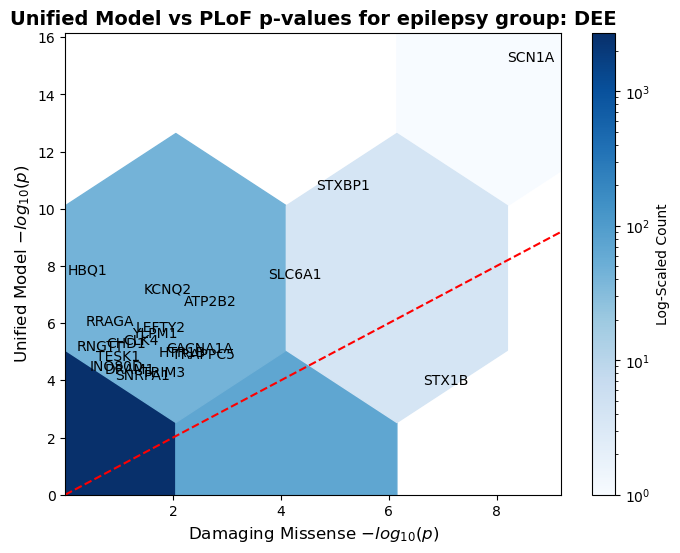

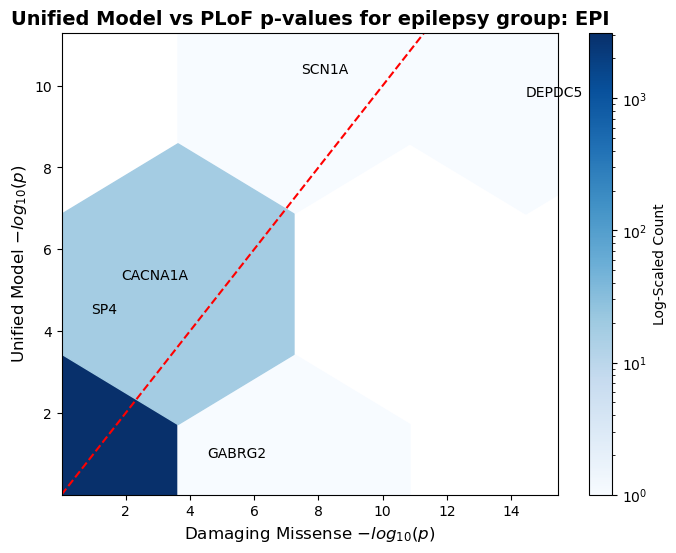

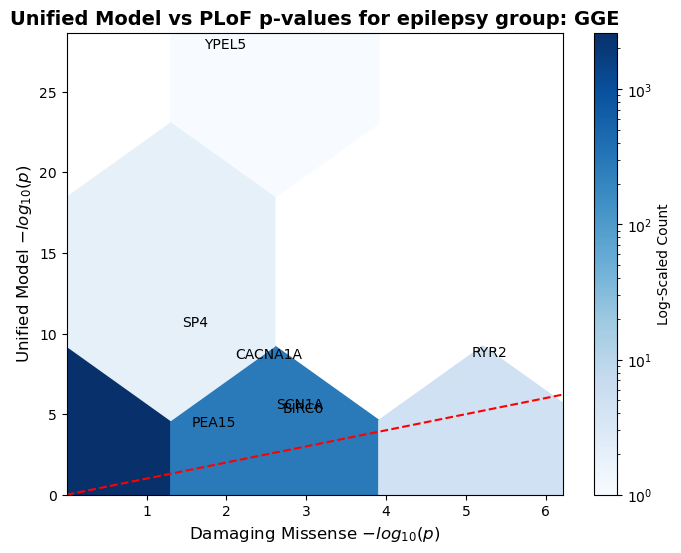

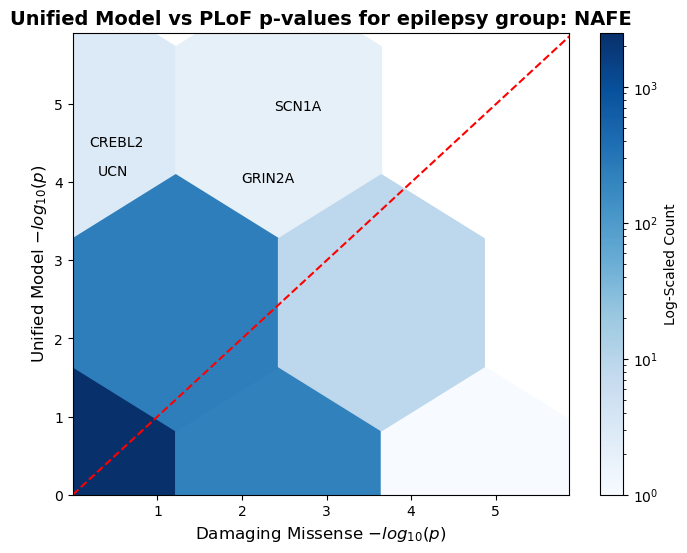

In [12]:
# Iterate over each unique group in the DataFrame to visualize the results
for group in unified_model_df['group'].unique():
    file_pattern = data_path + f"{group}_results_2023_12_30_14_36_*.csv"
    files = glob.glob(file_pattern)

    if files:
        # Load the corresponding publication results for the current group
        results_pub_df = pd.read_csv(files[0], sep=",")

        # Merge the meta-regression results with the publication data on gene_id
        merged_pub_df = pd.merge(unified_model_df[unified_model_df['group'] == group], results_pub_df, left_on='gene_id', right_on='Gene')

        # Compute -log10 of p-values for plotting
        merged_pub_df['minus_log_pval'] = -np.log10(merged_pub_df['p_unified'])
        merged_pub_df['minus_log_missense_pval'] = -np.log10(np.minimum(merged_pub_df['Damaging Missense p‑val'], merged_pub_df['PTV p‑val']))

        # Set up the plot
        plt.figure(figsize=(8, 6))

        # Replace Inf values with NaN for plotting
        merged_pub_df.replace([np.inf, -np.inf], np.nan, inplace=True)

        # Determine the minimum and maximum p-values for plotting axes
        min_pval_x = merged_pub_df['minus_log_missense_pval'].min()
        min_pval_y = merged_pub_df['minus_log_pval'].min()
        min_pval = np.nanmin([min_pval_x, min_pval_y])

        max_pval_x = merged_pub_df[~merged_pub_df['minus_log_pval'].isna()]['minus_log_missense_pval'].max()
        max_pval_y = merged_pub_df[~merged_pub_df['minus_log_missense_pval'].isna()]['minus_log_pval'].max()
        max_pval = np.nanmax([max_pval_x, max_pval_y])
        
        # Ensure min_pval and max_pval are valid numbers
        if np.isnan(min_pval):
            min_pval = 0  # Set to 0 if no valid values are found
        if np.isnan(max_pval):
            max_pval = 1  # Set to 1 if no valid values are found

        # Create a hexbin plot to visualize the relationship between the p-values
        plt.hexbin(merged_pub_df['minus_log_missense_pval'], merged_pub_df['minus_log_pval'], gridsize=2, cmap='Blues', norm=LogNorm())

        # Add a diagonal line for reference
        plt.plot([0, max_pval+1], [0, max_pval+1], color='red', linestyle='--')
        
        # Annotate genes where the difference between p-values is significant
        for _, row in merged_pub_df.iterrows():
            if (abs((row['minus_log_missense_pval'] - row['minus_log_pval'])) > 2) & (max(row['minus_log_missense_pval'], row['minus_log_pval']) > 4):
                plt.text(row['minus_log_missense_pval'], row['minus_log_pval'], row['gene_name'], fontsize=10)

        # Set axis limits and labels
        plt.xlim(min_pval_x, max_pval_x+1)
        plt.ylim(min_pval_y, max_pval_y+1)

        # Axis labels and title (bolded)
        plt.xlabel(r'Damaging Missense $-log_{10}(p)$', fontsize=12)
        plt.ylabel(r'Unified Model $-log_{10}(p)$', fontsize=12)
        plt.title(f'Unified Model vs PLoF p-values for epilepsy group: {group}', fontsize=14, fontweight="bold")

        # Add a color bar to the plot
        plt.colorbar(label='Log-Scaled Count')
        
        # Save the plot
        plt.savefig(results_path + f"Figure 3: p-value comparison for epilepsy genes in group {group}")

        # Show the plot
        plt.show()

    else:
        # If no files are found for the group, print a message
        print(f"No files found for group {group}")